# Time Series Explanation with tsCaptum

This notebook provides examples for training time series classifiers and regressors and explaining them using post-hoc attribution methods. The tsCaptum library makes it easy to train time series models using the sktime or aeon library and explain them using the captum library.

In [67]:
# Classic tabular ML algorithms
from sklearn.linear_model import RidgeCV,  LogisticRegression
from sklearn.ensemble import  ExtraTreesRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# Time series algorithms for feature extraction and classification/regression
from aeon.datasets import load_from_tsfile
from aeon.transformations.collection.convolution_based import MiniRocketMultivariate

import math
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from os.path import join
import sys
sys.path.append('./src/')
import timeit

np.set_printoptions(precision=2)


# Load time series classification and regression datasets

In [68]:
data_location = './src/tsCaptum/data/'
# https://www.aeon-toolkit.org/en/stable/examples/classification/classification.html
# From aeon: We recommend storing time series in 3D numpy array of shape (n_instances, n_channels, n_timepoints) 
# and where possible our single problem loaders will return a 3D numpy.
# load each sample in a 3d numpy array (n_samples, n_channels, n_timepoints)

# Univariate time series classification dataset from [1]
# [1] https://github.com/mlgig/xai4mtsc_eval_actionability
CMJ = np.load( join( data_location, "CMJ_univariate.npy"),allow_pickle=True).item()
CMJ_X_train =CMJ["train"]["X"]
CMJ_X_test = CMJ["test"]["X"]
CMJ_y_train =CMJ["train"]["y"]
CMJ_y_test = CMJ["test"]["y"]
print("univariate classification train and test", CMJ_X_train.shape, CMJ_y_train.shape, CMJ_X_test.shape, CMJ_y_test.shape)

# Multivariate time series classification dataset from [1]
MP = np.load( join( data_location, "MP_centered.npy"), allow_pickle=True).item()
MP_X_train =MP["train"]["X"]
MP_X_test = MP["test"]["X"]
MP_y_train =MP["train"]["y"]
MP_y_test = MP["test"]["y"]
print("multivariate classification train and test", MP_X_train.shape, MP_y_train.shape, MP_X_test.shape, MP_y_test.shape, "\n")

#Univariate time series regression dataset from [2]
# [2] https://github.com/mlgig/VM-challenge-lactose-prediction-2024
X_train_reg_uni = np.load( join( data_location, "milk_lactose_p75_train_X_2d.npy"))
X_train_reg_uni = X_train_reg_uni[:, np.newaxis, :]
y_train_reg_uni = pd.read_excel(join( data_location, 'milk_lactose_p75_train_targets.xlsx'), 0, engine='openpyxl')['lactose content']
X_test_reg_uni = np.load( join( data_location, "milk_lactose_p75_test_X_2d.npy"))
y_test_reg_uni = pd.read_excel(join( data_location, 'milk_lactose_p75_test_targets.xlsx'), 0, engine='openpyxl')['lactose content']
X_test_reg_uni = X_test_reg_uni[:, np.newaxis, :]
print("univariate classification train and test", X_train_reg_uni.shape, y_train_reg_uni.shape, X_test_reg_uni.shape, y_test_reg_uni.shape)

#Multivariate time series regresison dataset [3]
# [3] http://tseregression.org
X_train_reg, y_train_reg = load_from_tsfile( join( data_location, "AppliancesEnergy_TRAIN.ts"))
X_test_reg, y_test_reg = load_from_tsfile( join( data_location,"AppliancesEnergy_TEST.ts"))
print("regression train and test",X_train_reg.shape, y_train_reg.shape, X_test_reg.shape, y_test_reg.shape)


univariate classification train and test (419, 1, 500) (419,) (179, 1, 500) (179,)
multivariate classification train and test (1426, 8, 161) (1426,) (595, 8, 161) (595,) 

univariate classification train and test (64, 1, 3424) (64,) (8, 1, 3424) (8,)
regression train and test (95, 24, 144) (95,) (42, 24, 144) (42,)


## Univariate Time Series Classification

In [69]:
from aeon.classification.interval_based import QUANTClassifier
clf = QUANTClassifier()
clf.fit(CMJ_X_train, CMJ_y_train)
print ("QUANT accuracy:", clf.score(CMJ_X_test,CMJ_y_test),)

QUANT accuracy: 0.9553072625698324


## Explanation using Attribution Methods

We're explaining only 3 samples from the test set as a demo.

In [70]:
# number of samples to explain
n_to_explain = 3
CMJ_X_test_samples, CMJ_y_test_samples = CMJ_X_test[:n_to_explain], CMJ_y_test[:n_to_explain]

# Feature Ablation (a fast post-hoc attribution method to explain a time series)
1) instantiate your attribution method, the constructor takes only one mandatory argument namely the predictor and one optional argument, the predictor type (i.e., classifier or regressor). In case the last one isn't provided it's inferred by the availability of predict_proba in the predictor (if predict_proba is available, we infer the predictor is a classifier).
2) once we have the object, we call the method explain which returns a saliency map (attribution weights). Only one mandatory argument: the samples to be explained. 

Apart from the sample to explain, the explain method has some additional parameters:

		:param labels:      labels associated to samples in case of classification. The 'labels' parameter only make sense if you are using a classifier.
		:param batch_size:  the batch_size to be used i.e. number of samples to be explained at the same time
		:param n_segments:  number of segments the timeseries is divided into. This parameter impacts the speed/quality of the method. To explain point-wise, please provide -1 as a value for this parameter. 
		:param normalise:   whether or not to normalise the attribution weights to the [-1,1] interval
		:param baseline:    the baseline which will substitute the time series' values when ablated (this is also commonly known as a mask). It can be either a scalar (each time series's value is substituted by this scalar) or a single time series. By default it is set to 0.

DEFAULT VALUES:
def explain(self, samples, labels=None, batch_size=8, n_segments=10, normalise=False, baseline=0):


In [71]:
from tsCaptum.explainers import Feature_Ablation

starttime = timeit.default_timer()
myFA = Feature_Ablation(clf)
exp = myFA.explain(samples=CMJ_X_test_samples, labels=CMJ_y_test_samples, n_segments=10, normalise=False, baseline=0)
print("Time to explain (sec):", timeit.default_timer() - starttime)

print( "\nSaliency map shape equal to input shape:", exp.shape, CMJ_X_test_samples.shape,
       "\n attributions for first 10 time points at sample 0:\n", exp[0,:,:10])

8it [00:00,  9.78it/s]                                                                                                                             

Time to explain (sec): 0.8236458540195599

Saliency map shape equal to input shape: (3, 1, 500) (3, 1, 500) 
 attributions for first 10 time points at sample 0:
 [[-0.07 -0.07 -0.07 -0.07 -0.07 -0.07 -0.07 -0.07 -0.07 -0.07]]


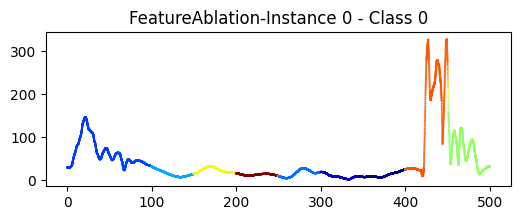

In [72]:
from tsCaptum.visualization import plot_saliency_map_uni
idx = 0
plot_saliency_map_uni(CMJ_X_test[idx,:,:], exp[idx,:,:], title = f'FeatureAblation-Instance {idx} - Class {CMJ_y_test[idx]}')

## Shapley Value Sampling (SHAP)

In [73]:
from tsCaptum.explainers import Shapley_Value_Sampling as SHAP

starttime = timeit.default_timer()
mySHAP = SHAP(clf)
exp = mySHAP.explain(CMJ_X_test_samples, labels=CMJ_y_test_samples, n_segments=10, normalise=False)
print("Time to explain (sec):", timeit.default_timer() - starttime)
print( "\nSaliency map shape equal to input shape:", exp.shape, CMJ_X_test_samples.shape,
       "\n attributions for first 10 time points at sample 0:\n", exp[0,:,:10])

8it [00:20,  2.58s/it]                                                                                                                             

Time to explain (sec): 20.671526174992323

Saliency map shape equal to input shape: (3, 1, 500) (3, 1, 500) 
 attributions for first 10 time points at sample 0:
 [[-0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01]]


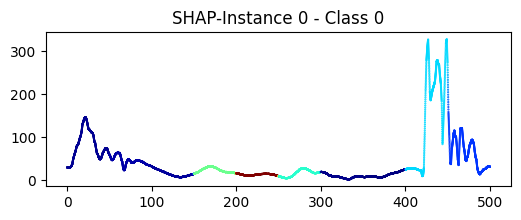

In [74]:
idx = 0
plot_saliency_map_uni(CMJ_X_test[idx,:,:], exp[idx,:,:], title = f'SHAP-Instance {idx} - Class {CMJ_y_test[idx]}')

An important optional argument is the baseline mask, i.e., the value(s) replacing the original time series values to check the impact of those data points on the predictor. 
This takes two possible formats for it:
 1) a scalar i.e. a single number replacing each value to be ablated (default value is 0).

In [75]:
starttime = timeit.default_timer()
mySHAP = SHAP(clf)
exp = mySHAP.explain(CMJ_X_test_samples, labels=CMJ_y_test_samples, baseline=0)
print("Time to explain (sec):", timeit.default_timer() - starttime)

8it [00:22,  2.79s/it]                                                                                                                             

Time to explain (sec): 22.314373031025752


2) a time series having the same shape as the one to be explained, usually one item from the train set



In [76]:
starttime = timeit.default_timer()
mySHAP = SHAP(clf)
exp = mySHAP.explain(CMJ_X_test_samples, labels=CMJ_y_test_samples, baseline=CMJ_X_train[0:1])
print("Time to explain (sec):", timeit.default_timer() - starttime)

8it [00:22,  2.80s/it]                                                                                                                             

Time to explain (sec): 22.387356424995232


# Kernel SHAP and LIME
For kernel SHAP and Lime the Captum framework suggests to use a batch size = 1, we are enforcing this property 

In [77]:
from tsCaptum.explainers import Kernel_Shap

starttime = timeit.default_timer()
myKernelSHAP = Kernel_Shap(clf)
exp = myKernelSHAP.explain(CMJ_X_test_samples, labels=CMJ_y_test_samples, batch_size=4)
print("Time to explain (sec):", timeit.default_timer() - starttime)

/Users/georgianaifrim/miniconda3/envs/comp47350py311/lib/python3.11/site-packages/tsCaptum/explainers.py:190: UserWarning: batch_size set to 1 as suggested by Captum for Lime and KernelSHAP
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.57s/it]

Time to explain (sec): 7.7171205779886805


In [ ]:
from tsCaptum.explainers import  LIME

starttime = timeit.default_timer()
myLIME = LIME(clf)
exp = myLIME.explain(CMJ_X_test_samples, labels=CMJ_y_test_samples, batch_size=6)
print("Time to explain (sec):", timeit.default_timer() - starttime)

/Users/georgianaifrim/miniconda3/envs/comp47350py311/lib/python3.11/site-packages/tsCaptum/explainers.py:217: UserWarning: batch_size set to 1 as suggested by Captum for Lime and KernelSHAP
  warnings.warn(
 67%|██████████████████████████████████████████████████████████████████████████▋                                     | 2/3 [00:04<00:02,  2.46s/it]

# Feature Permutation 
This is another example explainer; this method does not accept a baseline as argument.

In [ ]:
from tsCaptum.explainers import Feature_Permutation

starttime = timeit.default_timer()
myFP = Feature_Permutation(clf,clf_type="classifier")
exp = myFP.explain(CMJ_X_test_samples, labels=CMJ_y_test_samples, baseline=42)
print("Time to explain (sec):", timeit.default_timer() - starttime)

# Multivariate Time Series Classification

## Minirocket classifier, followed by Feature Ablation explainer

In [20]:
starttime = timeit.default_timer()

clf_MTS = make_pipeline(MiniRocketMultivariate(n_jobs=-1),
                        StandardScaler(),
                        LogisticRegression(n_jobs=-1))
clf_MTS.fit(MP_X_train,MP_y_train)
print("accuracy is", clf_MTS.score(MP_X_test,MP_y_test))

print("Time to train and test (sec):", timeit.default_timer() - starttime)

/Users/georgianaifrim/miniconda3/envs/comp47350py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy is 0.7327731092436974
Time to train and test (sec): 21.030897176999133


## Exaplanation using Attribution Methods

In [21]:
n_to_explain = 3
MP_X_test_samples, MP_y_test_samples = MP_X_test[:n_to_explain], MP_y_test[:n_to_explain]

In [24]:
starttime = timeit.default_timer()

myFA_MTS = Feature_Ablation(clf_MTS, clf_type="classifier")
exp = myFA_MTS.explain( samples= MP_X_test_samples, labels=MP_y_test_samples, batch_size=8, n_segments=10, normalise=False, baseline=0)

print("Time to explain (sec):", timeit.default_timer() - starttime)

print( "\nSaliency map shape equal to input shape:", exp.shape, MP_X_test_samples.shape,
       "\n attributions for first 10 time points in the first 4 channels:\n", exp[0,:4,:10])

8it [00:00, 11.40it/s]                                                                                                                             

Time to explain (sec): 0.7090357230044901

Saliency map shape equal to input shape: (3, 8, 161) (3, 8, 161) 
 attributions for first 10 time points in the first 4 channels:
 [[-0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09 -0.09]
 [ 0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05]
 [ 0.34  0.34  0.34  0.34  0.34  0.34  0.34  0.34  0.34  0.34]
 [-0.53 -0.53 -0.53 -0.53 -0.53 -0.53 -0.53 -0.53 -0.53 -0.53]]


channel: 0


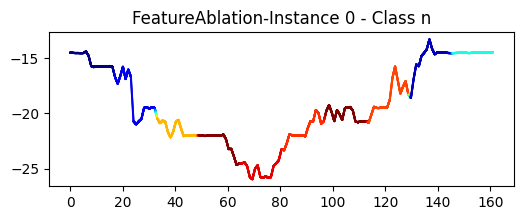

channel: 1


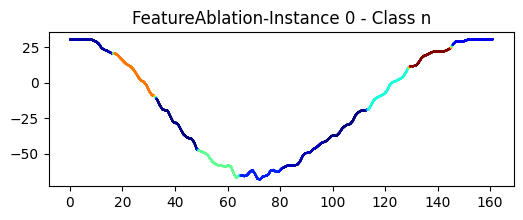

channel: 2


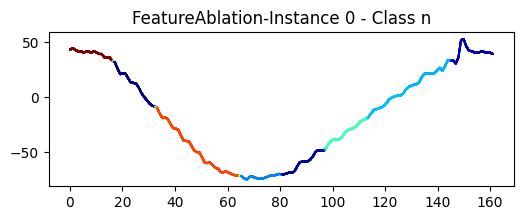

channel: 3


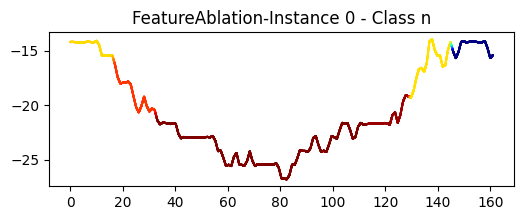

channel: 4


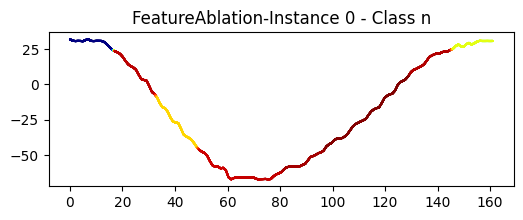

channel: 5


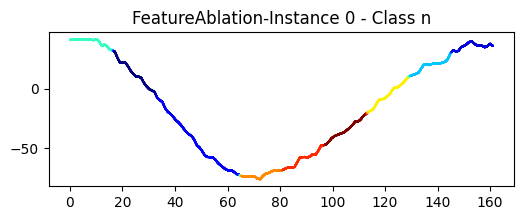

channel: 6


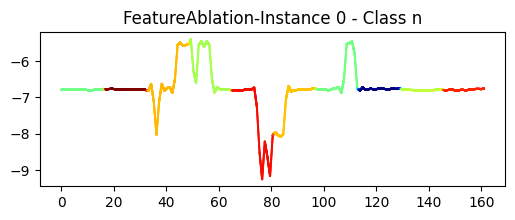

channel: 7


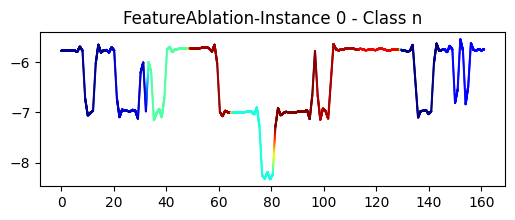

In [25]:
idx = 0
for ch in range(MP_X_test.shape[1]):
    print("channel:", ch)
    plot_saliency_map_uni(MP_X_test[idx,ch,:], exp[idx,ch,:], title = f'FeatureAblation-Instance {idx} - Class {MP_y_test[idx]}')

## We try different classifiers and different arguments for attribution.

## MUSE classifier and Feature Ablation explainer

In [26]:
from aeon.classification.dictionary_based import MUSE

starttime = timeit.default_timer()
clf_MTS = MUSE(window_inc=4, use_first_order_differences=False, support_probabilities=True)
clf_MTS.fit(MP_X_train,MP_y_train)
print("accuracy is", clf_MTS.score(MP_X_test,MP_y_test))
print("Time to train and test (sec):", timeit.default_timer() - starttime)

accuracy is 0.6823529411764706
Time to train and test (sec): 126.38343941397034


In [27]:
starttime = timeit.default_timer()
myFA_MTS = Feature_Ablation(clf_MTS, clf_type="classifier")
exp = myFA_MTS.explain(samples= MP_X_test_samples, labels=MP_y_test_samples, n_segments=10)
print("Time to explain (sec):", timeit.default_timer() - starttime)

print( "\nSaliency map shape equal to input shape:", exp.shape, MP_X_test_samples.shape,
       "\n attributions for first 10 time points in the first 4 channels:\n", exp[0,:4,:10])

starttime = timeit.default_timer()
myFA_MTS = Feature_Ablation(clf_MTS, clf_type="classifier")
exp = myFA_MTS.explain(samples= MP_X_test_samples, labels=MP_y_test_samples, n_segments=20)
print("Time to explain (sec):", timeit.default_timer() - starttime)

print( "\nSaliency map shape equal to input shape:", exp.shape, MP_X_test_samples.shape,
       "\n attributions for first 10 time points in the first 4 channels:\n", exp[0,:4,:10])

8it [00:15,  1.88s/it]                                                                                                                             


Time to explain (sec): 15.061668823997024

Saliency map shape equal to input shape: (3, 8, 161) (3, 8, 161) 
 attributions for first 10 time points in the first 4 channels:
 [[ 1.00e-04  1.00e-04  1.00e-04  1.00e-04  1.00e-04  1.00e-04  1.00e-04
   1.00e-04  1.00e-04  1.00e-04]
 [-9.55e-05 -9.55e-05 -9.55e-05 -9.55e-05 -9.55e-05 -9.55e-05 -9.55e-05
  -9.55e-05 -9.55e-05 -9.55e-05]
 [ 3.74e-04  3.74e-04  3.74e-04  3.74e-04  3.74e-04  3.74e-04  3.74e-04
   3.74e-04  3.74e-04  3.74e-04]
 [ 5.70e-05  5.70e-05  5.70e-05  5.70e-05  5.70e-05  5.70e-05  5.70e-05
   5.70e-05  5.70e-05  5.70e-05]]


8it [00:33,  4.24s/it]                                                                                                                             

Time to explain (sec): 33.8907351490343

Saliency map shape equal to input shape: (3, 8, 161) (3, 8, 161) 
 attributions for first 10 time points in the first 4 channels:
 [[ 9.30e-05  9.30e-05  9.30e-05  9.30e-05  9.30e-05  9.30e-05  9.30e-05
   9.30e-05  9.30e-05  1.79e-04]
 [ 3.32e-05  3.32e-05  3.32e-05  3.32e-05  3.32e-05  3.32e-05  3.32e-05
   3.32e-05  3.32e-05 -4.82e-04]
 [ 6.63e-05  6.63e-05  6.63e-05  6.63e-05  6.63e-05  6.63e-05  6.63e-05
   6.63e-05  6.63e-05  3.80e-04]
 [-4.51e-05 -4.51e-05 -4.51e-05 -4.51e-05 -4.51e-05 -4.51e-05 -4.51e-05
  -4.51e-05 -4.51e-05  7.37e-05]]


## QUANT classifier and Feature Ablation explainer

In [28]:
from aeon.classification.interval_based import QUANTClassifier

starttime = timeit.default_timer()
clf_MTS = QUANTClassifier()
clf_MTS.fit(MP_X_train,MP_y_train)
print("accuracy is", clf_MTS.score(MP_X_test,MP_y_test))
print("Time to train and test (sec):", timeit.default_timer() - starttime)

accuracy is 0.6907563025210084
Time to train and test (sec): 66.67201408999972


In [29]:
starttime = timeit.default_timer()
myFA_MTS = Feature_Ablation(clf_MTS, clf_type="classifier")
exps = myFA_MTS.explain( samples= MP_X_test_samples, labels=MP_y_test_samples, n_segments=10, normalise=False)
print("Time to explain (sec):", timeit.default_timer() - starttime)

print(" min and max attribution without normalisation:")
for i,exp in enumerate(exps):
	print( i , '{:.4f}'.format(exp.min()),"\t", '{:.4f}'.format(exp.max()) )


starttime = timeit.default_timer()
myFA_MTS = Feature_Ablation(clf_MTS, clf_type="classifier")
exps = myFA_MTS.explain( samples= MP_X_test_samples, labels=MP_y_test_samples, n_segments=10, normalise=True)
print("Time to explain (sec):", timeit.default_timer() - starttime)

print(" min and max attribution with normalisation to [-1,1]:")
for i,exp in enumerate(exps):
	print( i , '{:.4f}'.format(exp.min()),"\t", '{:.4f}'.format(exp.max()) )

8it [00:09,  1.15s/it]                                                                                                                             


Time to explain (sec): 9.224839595030062
 min and max attribution without normalisation:
0 -0.0650 	 0.0900
1 -0.1350 	 0.0450
2 -0.0100 	 0.0600


8it [00:09,  1.20s/it]                                                                                                                             

Time to explain (sec): 9.5809479340096
 min and max attribution with normalisation to [-1,1]:
0 -0.7222 	 1.0000
1 -1.0000 	 0.3333
2 -0.1667 	 1.0000


## Rocket classifier followed by Feature Ablation explainer

In [30]:
from aeon.classification.convolution_based import RocketClassifier

starttime = timeit.default_timer()
clf_MTS = RocketClassifier(n_jobs=-1)
clf_MTS.fit(MP_X_train,MP_y_train)
print("accuracy is", clf_MTS.score(MP_X_test,MP_y_test))
print("Time to train and test (sec):", timeit.default_timer() - starttime)

accuracy is 0.7495798319327731
Time to train and test (sec): 86.04932897898834


In [31]:
starttime = timeit.default_timer()
myFA_MTS = Feature_Ablation(clf_MTS, clf_type="classifier")
exps = myFA_MTS.explain( samples= MP_X_test_samples, labels=MP_y_test_samples, n_segments=10, normalise=False)
print("Time to explain (sec):", timeit.default_timer() - starttime)

8it [00:17,  2.19s/it]                                                                                                                             

Time to explain (sec): 17.55093669600319


## Pipeline with a Rocket transform, followed by explainer applied to the pipeline

In [32]:
from aeon.transformations.collection.convolution_based import Rocket

starttime = timeit.default_timer()

clf_MTS = make_pipeline(Rocket(n_jobs=-1),
                        StandardScaler(),
                        LogisticRegression(n_jobs=-1))

clf_MTS.fit(MP_X_train,MP_y_train)
print("accuracy is", clf_MTS.score(MP_X_test,MP_y_test))
print("Time to train and test (sec):", timeit.default_timer() - starttime)

/Users/georgianaifrim/miniconda3/envs/comp47350py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy is 0.7831932773109244
Time to train and test (sec): 110.76744936796604


In [33]:
starttime = timeit.default_timer()
myFA_MTS = Feature_Ablation(clf_MTS, clf_type="classifier")
exps = myFA_MTS.explain( samples= MP_X_test_samples, labels=MP_y_test_samples, n_segments=10, normalise=False)
print("Time to explain (sec):", timeit.default_timer() - starttime)

8it [00:17,  2.15s/it]                                                                                                                             

Time to explain (sec): 17.19610618700972


=============================================================================================

# Time Series Regression and Explanation using Attribution

## Univariate Time Series Regression and Explanation

## Pipeline of Rocket transform and ExtraTreesRegressor for regression, followed by explainer

In [34]:
starttime = timeit.default_timer()

regressor = make_pipeline(
            Rocket(normalise=True, num_kernels=10000, n_jobs=-1, random_state=142),
            StandardScaler(),
            SelectFromModel(RidgeCV()),
            ExtraTreesRegressor(n_estimators=100, random_state=142),
        )

regressor.fit(X_train_reg_uni, y_train_reg_uni)
test_y_pred_reg_uni = regressor.predict(X_test_reg_uni)
rmse = math.sqrt(mean_squared_error(y_test_reg_uni, test_y_pred_reg_uni))
print("rmse metric is: ", rmse)
print(test_y_pred_reg_uni)
print("Time to train and test (sec):", timeit.default_timer() - starttime)

rmse metric is:  9.803333616683664
[71.86 59.64 53.14 60.24 22.78 51.52 49.24 23.8 ]
Time to train and test (sec): 15.445015195000451


In [35]:
n_to_explain = 3
X_test_reg_uni_samples, y_test_reg_uni_samples = X_test_reg_uni[:n_to_explain], y_test_reg_uni[:n_to_explain]

starttime = timeit.default_timer()
myFA = Feature_Ablation(regressor)
exp = myFA.explain(samples=X_test_reg_uni_samples, n_segments=10, normalise=False)
print( "saliency map shape equal to input shape:", exp.shape, X_test_reg_uni_samples.shape,
       "\n attributions for first 20 time points:\n", exp[0,:,:20])
print("Time to explain (sec):", timeit.default_timer() - starttime)

#starttime = timeit.default_timer()
#exp = myFA.explain(samples=X_test_reg_uni, n_segments=20, normalise=True)
#print( "normalised saliency map shape equal to input shape:", exp.shape, X_test_reg_uni.shape,
#       "\n attributions for first 20 time points:\n", exp[0,:,:20])
#print("Time to explain (sec):", timeit.default_timer() - starttime)

8it [00:07,  1.14it/s]                                                                                                                             

saliency map shape equal to input shape: (3, 1, 3424) (3, 1, 3424) 
 attributions for first 20 time points:
 [[0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
  0.9 0.9]]
Time to explain (sec): 7.055238677014131


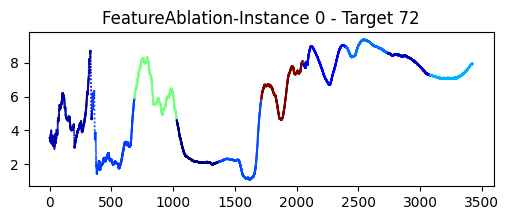

In [36]:
idx = 0
plot_saliency_map_uni(X_test_reg_uni[idx,:,:], exp[idx,:,:], title = f'FeatureAblation-Instance {idx} - Target {y_test_reg_uni[idx]}')

In [37]:
n_to_explain = 3
X_test_reg_uni_samples, y_test_reg_uni_samples = X_test_reg_uni[:n_to_explain], y_test_reg_uni[:n_to_explain]

starttime = timeit.default_timer()
mySHAP = SHAP(regressor)
exp = mySHAP.explain(samples=X_test_reg_uni_samples, n_segments=10, normalise=False)
print( "saliency map shape equal to input shape:", exp.shape, X_test_reg_uni_samples.shape,
       "\n attributions for first 20 time points:\n", exp[0,:,:20])
print("Time to explain (sec):", timeit.default_timer() - starttime)

8it [02:36, 19.50s/it]                                                                                                                             

saliency map shape equal to input shape: (3, 1, 3424) (3, 1, 3424) 
 attributions for first 20 time points:
 [[3.49 3.49 3.49 3.49 3.49 3.49 3.49 3.49 3.49 3.49 3.49 3.49 3.49 3.49
  3.49 3.49 3.49 3.49 3.49 3.49]]
Time to explain (sec): 156.04844084294746


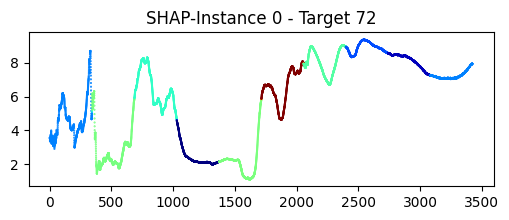

In [38]:
idx = 0
plot_saliency_map_uni(X_test_reg_uni[idx,:,:], exp[idx,:,:], title = f'SHAP-Instance {idx} - Target {y_test_reg_uni[idx]}')

## Multivariate Time Series Regression and Explanation

## Regression pipeline using MiniRocket, followed by FeatureAblation explainer

In [39]:
starttime = timeit.default_timer()

regressor = make_pipeline(MiniRocketMultivariate(n_jobs=-1),
                          StandardScaler(), 
                          RidgeCV())

regressor.fit(X_train_reg, y_train_reg)
test_y_pred = regressor.predict(X_test_reg)
rmse = math.sqrt(mean_squared_error(y_test_reg, test_y_pred))
print("rmse metric is: ", rmse)
print("Time to train and test (sec):", timeit.default_timer() - starttime)

rmse metric is:  2.4000162043332893
Time to train and test (sec): 0.27090301999123767


In [40]:
n_to_explain = 3
X_test_reg, y_test_reg = X_test_reg[:n_to_explain], y_test_reg[:n_to_explain]

starttime = timeit.default_timer()
myFA = Feature_Ablation(regressor)
exp = myFA.explain(samples=X_test_reg, n_segments=10, normalise=False)
print( "\nSaliency map shape equal to input shape:", exp.shape, X_test_reg_uni.shape,
       "\n attributions for first 5 time points in the first 3 channels of samples 0:\n", exp[0,:3,:5])
print("Time to explain (sec):", timeit.default_timer() - starttime)    


8it [00:02,  3.96it/s]                                                                                                                             


Saliency map shape equal to input shape: (3, 24, 144) (8, 1, 3424) 
 attributions for first 5 time points in the first 3 channels of samples 0:
 [[-0.02 -0.02 -0.02 -0.02 -0.02]
 [-0.73 -0.73 -0.73 -0.73 -0.73]
 [ 0.78  0.78  0.78  0.78  0.78]]
Time to explain (sec): 2.026221432024613


channel: 0


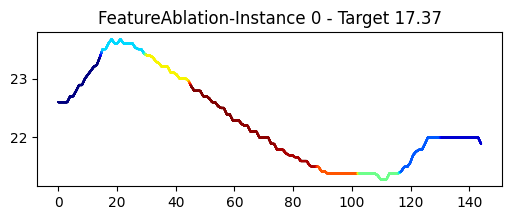

channel: 1


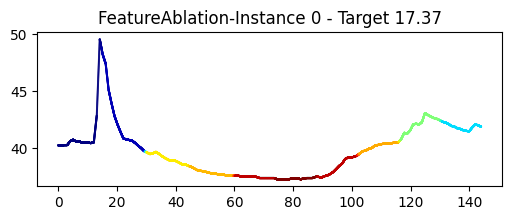

channel: 2


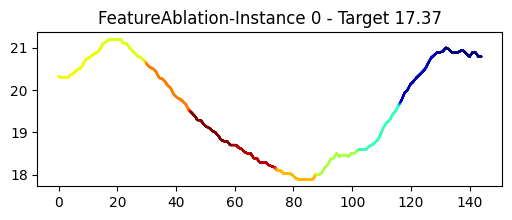

channel: 3


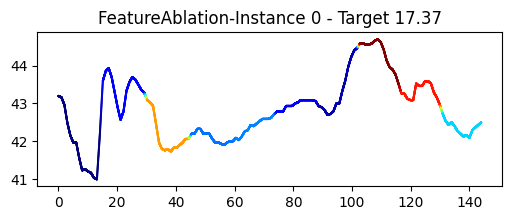

channel: 4


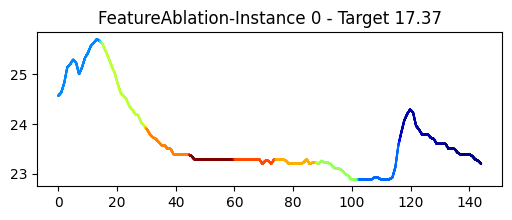

channel: 5


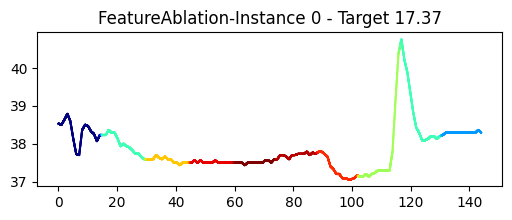

channel: 6


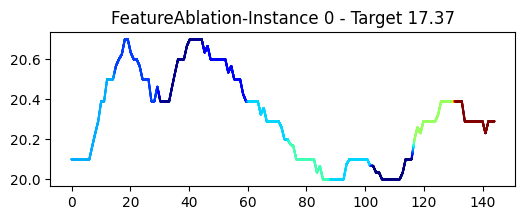

channel: 7


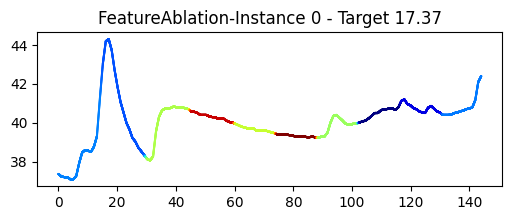

channel: 8


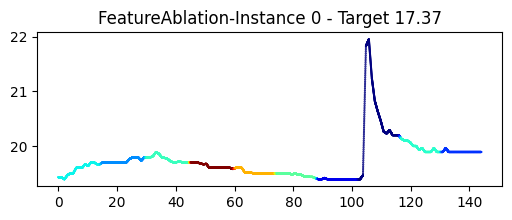

channel: 9


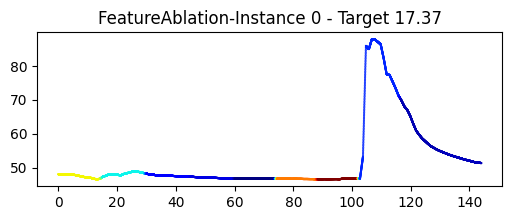

channel: 10


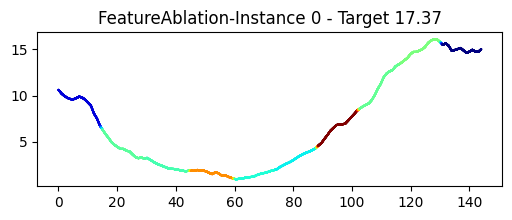

channel: 11


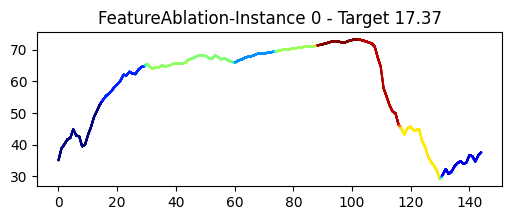

channel: 12


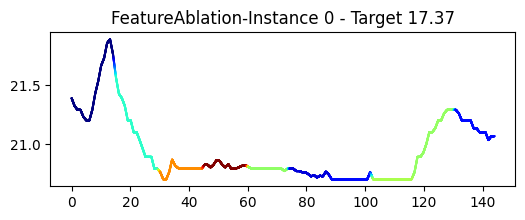

channel: 13


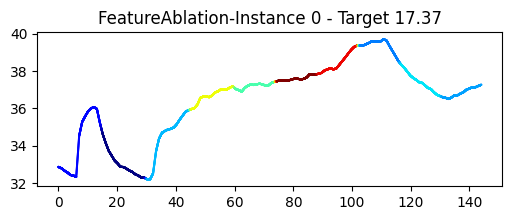

channel: 14


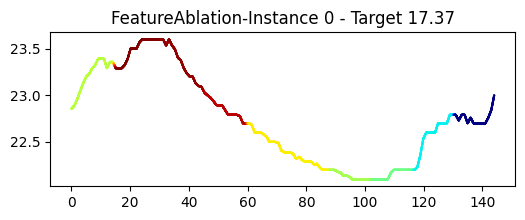

channel: 15


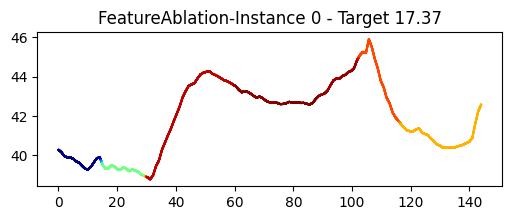

channel: 16


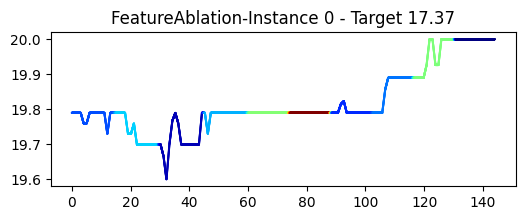

channel: 17


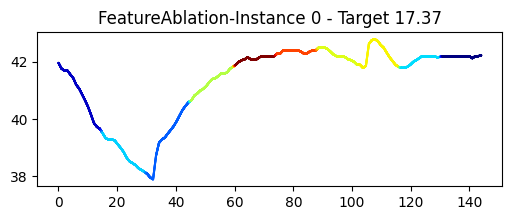

channel: 18


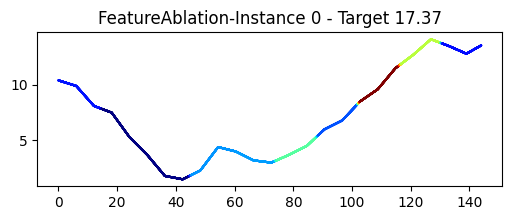

channel: 19


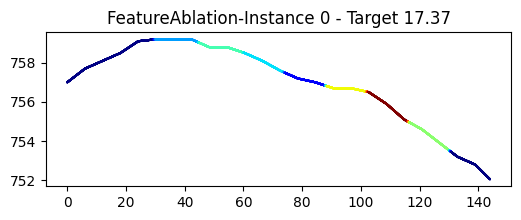

channel: 20


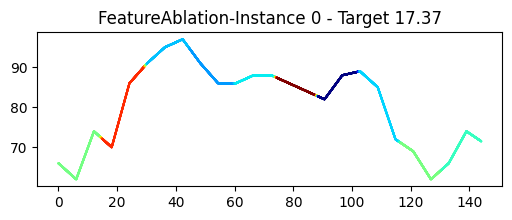

channel: 21


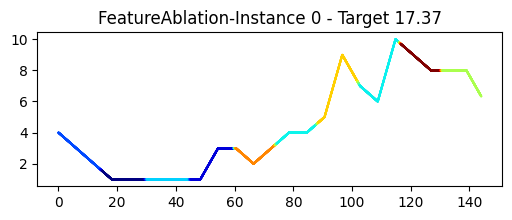

channel: 22


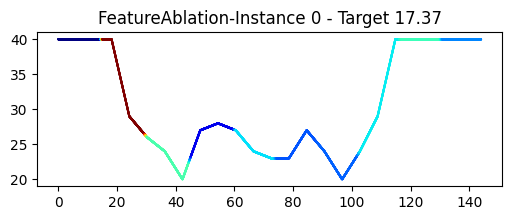

channel: 23


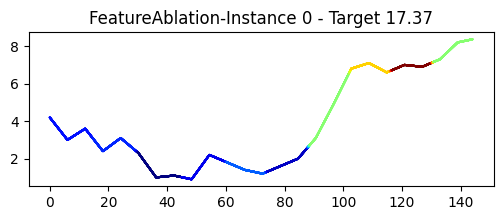

In [41]:
idx = 0
for ch in range(X_test_reg.shape[1]):
    print("channel:", ch)
    plot_saliency_map_uni(X_test_reg[idx,ch,:], exp[idx,ch,:], title = f'FeatureAblation-Instance {idx} - Target {y_test_reg[idx]}')